# Extended Linear Regression

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# Global plot settings
plt.style.use('fivethirtyeight')
plt.rcParams['figure.dpi'] = 150   # Set the resolution of the plots to 150 DPI

import statsmodels.api as sm            # For statistical models
import statsmodels.formula.api as smf  # For statistical modeling
from sklearn.metrics import mean_absolute_error, mean_squared_error

Importing datasets

In [ ]:
# Load the datasets

# file paths
train_path = '/workspaces/bakery_prediction/0_DataPreparation/Split_data/01_split_data/train_data.csv'
val_path = '/workspaces/bakery_prediction/0_DataPreparation/Split_data/01_split_data/val_data.csv'
test_path = '/workspaces/bakery_prediction/0_DataPreparation/Split_data/01_split_data/test_data.csv'


train_df = pd.read_csv('train_data.csv')
val_df = pd.read_csv('val_data.csv')
test_df = pd.read_csv('test_data.csv')

train_df.head()

,id,Datum,Warengruppe,Umsatz,KielerWoche,Bewoelkung,Temperatur,Windgeschwindigkeit,Woche,Monat,Wochentag,Feiertag,Jahreszeit,Ferien,sunny,cloudy,rainy,thunderstorm
0,1307011,2013-07-01,1,148.828353,0,6,17.8375,15,27,7,1,0,3,0,0,1,0,0
1,1307012,2013-07-01,2,535.856285,0,6,17.8375,15,27,7,1,0,3,0,0,1,0,0
2,1307013,2013-07-01,3,201.198426,0,6,17.8375,15,27,7,1,0,3,0,0,1,0,0
3,1307014,2013-07-01,4,65.890169,0,6,17.8375,15,27,7,1,0,3,0,0,1,0,0
4,1307015,2013-07-01,5,317.475875,0,6,17.8375,15,27,7,1,0,3,0,0,1,0,0


Seeing the Correlation Matrix

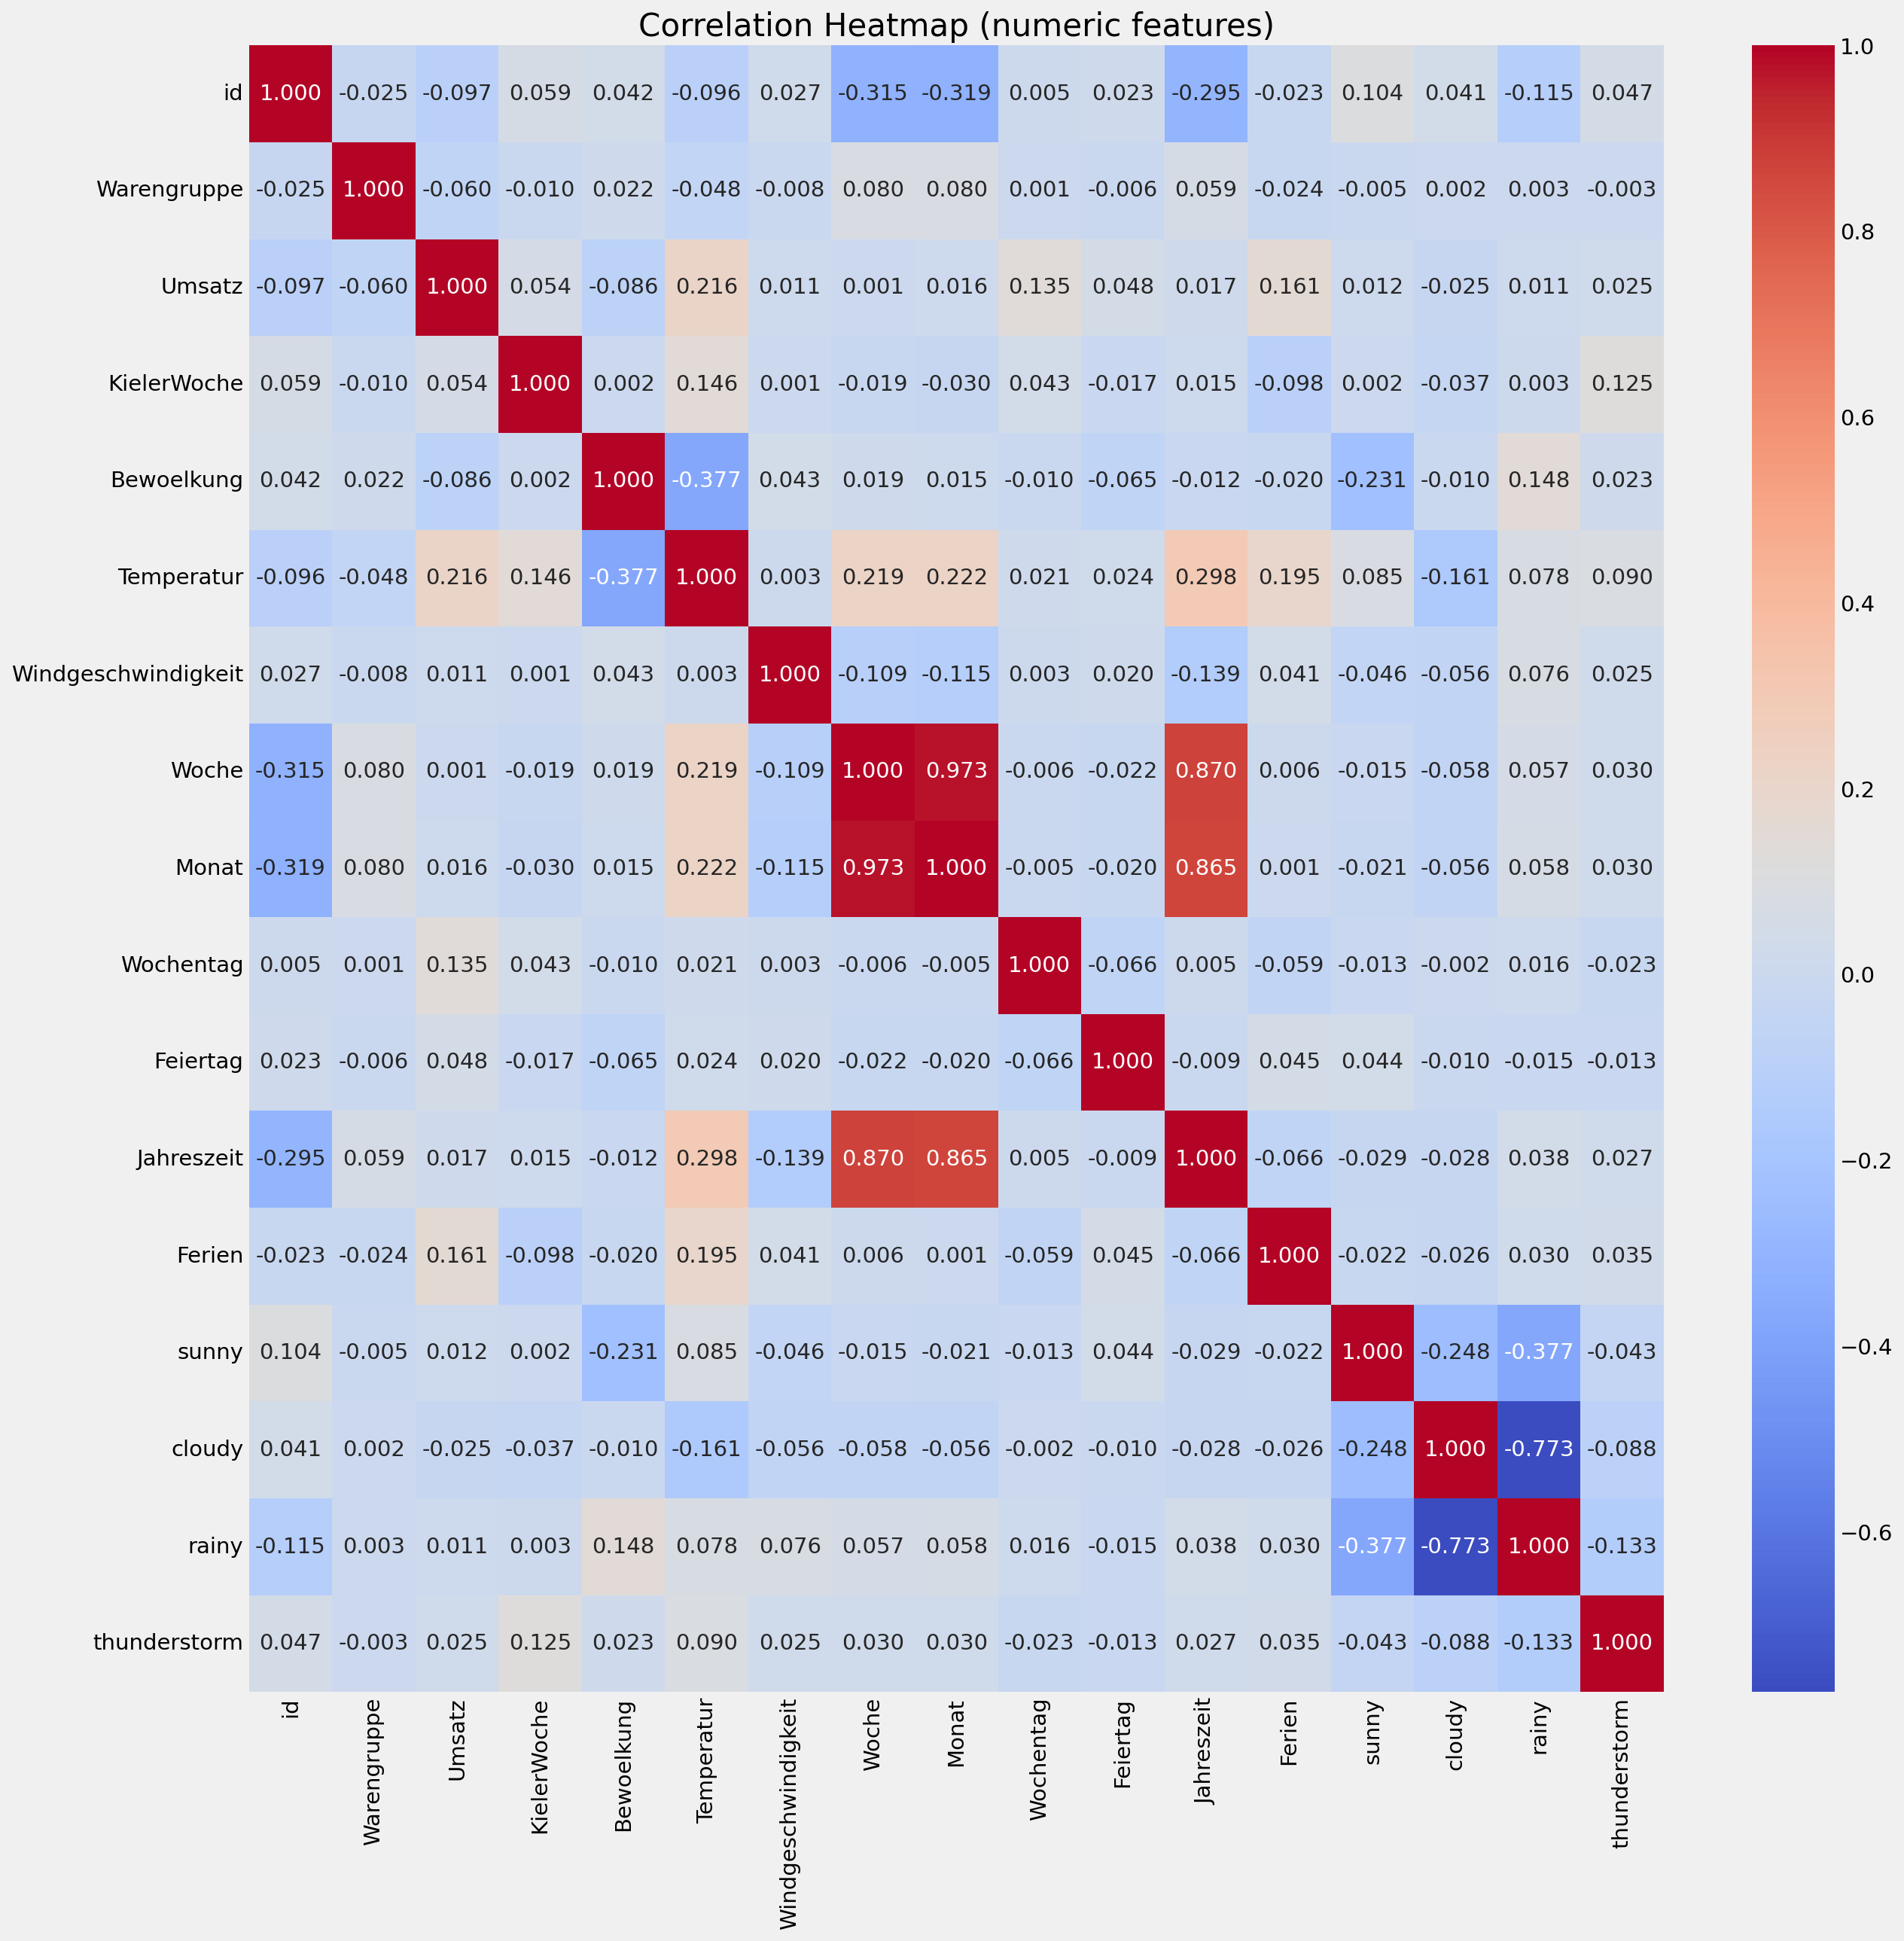

In [ ]:
# The filtered data with only numerical features
df_num_feature = train_df.select_dtypes(include=[np.number])

correlation_matrix = df_num_feature.corr()

plt.figure(figsize=(18,18))
sns.heatmap(correlation_matrix, annot=True, fmt=".3f", cmap='coolwarm')
plt.title("Correlation Heatmap (numeric features)")
plt.show()

## Initial attempt

*Numerical Vars*
- Bewoelkung
- Temperatur
- Feiertag
- Ferien
  
*Categorical Vars*
- Warengruppe
- Wochentag

*Target Var*
- Umsatz

## Extended Version

Now we will change the regression equation. Basically we are dealing with time series data. A simple linear term might not catch the full effect. So we will model the *cyclic effect* of month and weekdays in a modified regression equation. And we will let the product group interact with the modified variables.

So in our initial Linear regression equation all the terms were additive.

But now after doing some *feature engineering* we are introducting the so called **Interaction Effects** - where multiple variables interact with each other. Our regression equation will now be of this form -

$y = b_0 + b_1 . x_1 + b_2 . x_2 + b_3 . (x_1 + x_2 + x_3)$


Our argument is the sales of individual product categories depends on Temperature and if it is a special day (weekend/ public holiday/ school hoilday/ kieler woche). We will also introduce the sine and the cosine transformation of Weekday and Month Number to catch their cyclic effects.

### Preprocessing

- adding weekend flag (0/1)
- adding sine and cosine transformation (like x,y co-ordinate) of Week and Month num

In [ ]:

# Preprocessing Function
def preprocess(df):
    df = df.copy()
    df['Datum'] = pd.to_datetime(df['Datum'])
    
    # Verify Wochentag: 1=Monday...7=Sunday based on 2013-07-01 being Monday and having Wochentag=1
    # Create is_weekend (Saturday=6, Sunday=7)
    df['is_weekend'] = df['Wochentag'].apply(lambda x: 1 if x >= 6 else 0)
    
    # Cyclical Features for Month (period=12)
    df['sin_Monat'] = np.sin(2 * np.pi * df['Monat'] / 12)
    df['cos_Monat'] = np.cos(2 * np.pi * df['Monat'] / 12)
    
    # Cyclical Features for Wochentag (period=7)
    df['sin_Wochentag'] = np.sin(2 * np.pi * df['Wochentag'] / 7)
    df['cos_Wochentag'] = np.cos(2 * np.pi * df['Wochentag'] / 7)
    
    # Cyclical Features for Jahreszeit (Season) - period 4? Or just use as categorical?
    # Previous model used it as numeric (-1.93 coeff). 
    # Let's treat it as categorical C(Jahreszeit) or keep it numeric if it implies order (1=Spring, 2=Summer...?)
    # Let's assume it's categorical for safety in the formula.
    
    return df



# Apply preprocessing to all datasets
train_df = preprocess(train_df)
val_df = preprocess(val_df)
test_df = preprocess(test_df)



### Performing the extended Linear Regression

In [ ]:
# Define Formula
# We want to maximize Adjusted R-squared. 
# Strategy: Allow Warengruppe (Product Group) to interact with key drivers.
# Hypothesis:
# 1. Sales patterns differ by product (C(Warengruppe)).
# 2. Weekend effect differs by product (e.g., Bread vs Cakes).
# 3. KielerWoche effect differs by product.
# 4. Temperature effect differs by product.
# 5. Seasonality (Monat) is global or per product? Let's start global cyclical + simple trend.

formula = (
    "Umsatz ~ C(Warengruppe) * (KielerWoche + is_weekend + Temperatur + Ferien + Feiertag) "
    "+ sin_Monat + cos_Monat + sin_Wochentag + cos_Wochentag"
)

# Fit Model
model = smf.ols(formula=formula, data=train_df).fit()

# Print Summary to check R-squared and Adj. R-squared
print(model.summary())



                            OLS Regression Results                            
Dep. Variable:                 Umsatz   R-squared:                       0.814
Model:                            OLS   Adj. R-squared:                  0.813
Method:                 Least Squares   F-statistic:                     883.2
Date:                Thu, 04 Dec 2025   Prob (F-statistic):               0.00
Time:                        11:28:12   Log-Likelihood:                -41757.
No. Observations:                7493   AIC:                         8.359e+04
Df Residuals:                    7455   BIC:                         8.385e+04
Df Model:                          37                                         
Covariance Type:            nonrobust                                         
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
Intercept 

#### On validation set

Lets see the model performance on the validation set and get a plot.


Validation MAE: 38.32
Validation RMSE: 57.13


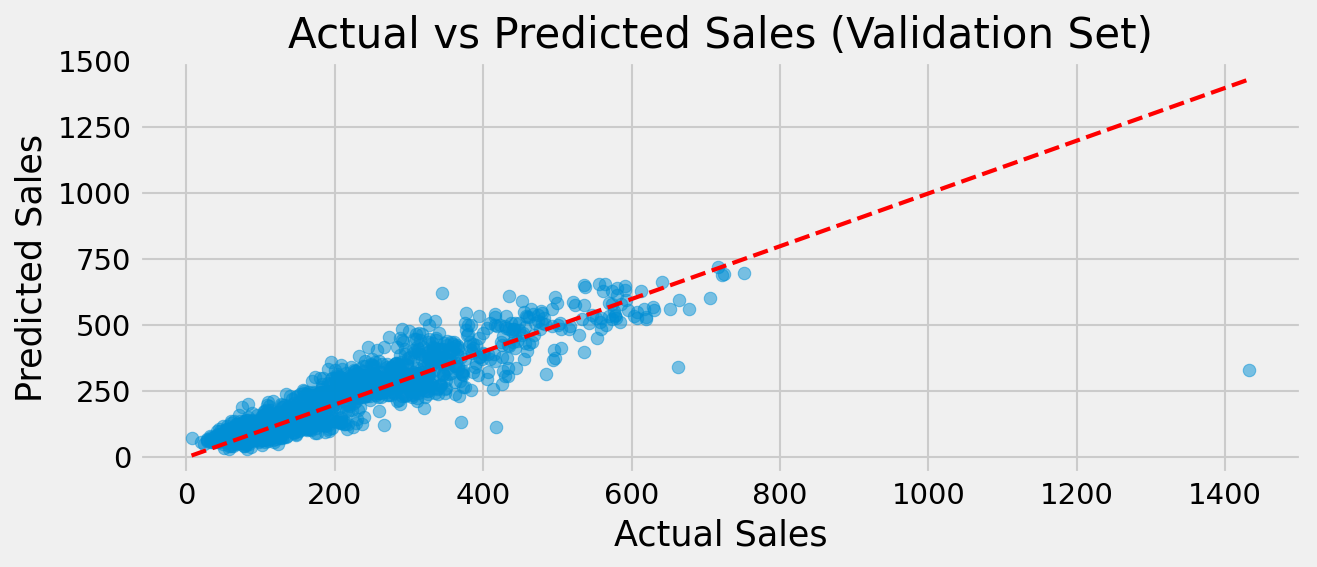

In [ ]:
y_pred_val = model.predict(val_df)        # prediction on validation set
y_val = val_df['Umsatz']                      # actual values

# Calculate MAE and RMSE on Validation Set (model evaluation metrics)         
mae_val = mean_absolute_error(y_val, y_pred_val)
rmse_val = np.sqrt(mean_squared_error(y_val, y_pred_val))

print(f"\nValidation MAE: {mae_val:.2f}")
print(f"Validation RMSE: {rmse_val:.2f}")


# ---------- Plotting Predictions vs Actuals on Validation Set ----------

# Plots
plt.figure(figsize=(9, 4))
plt.scatter(y_val, y_pred_val, alpha=0.5)
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'r--', lw=2)
plt.xlabel('Actual Sales')
plt.ylabel('Predicted Sales')
plt.title('Actual vs Predicted Sales (Validation Set)')
plt.tight_layout()

#### Predict and Save Results

In [ ]:
# Predict on Test
predictions = model.predict(test_df)
predictions = np.maximum(predictions, 0) # Clip negative values to zero



Predictions saved.


Creating the submission data frame

In [ ]:
# Create submission DataFrame
submission_df = pd.DataFrame({
    'id': test_df['id'],
    'Umsatz': predictions
})

# Save to CSV
submission_file_name = 'enriched_linear_submission.csv'
workspace_path = "/workspaces/bakery_prediction/2_BaselineModel/01_Lin_Reg/prediction/"
submission_file = workspace_path + submission_file_name

submission_df.to_csv(submission_file, index=False)

print(f"\nPredictions saved to {submission_file}")
print(submission_df.head())